In [5]:
from dtw import dtw, accelerated_dtw
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from collections import defaultdict

In [17]:
def get_reference_points(dataset, w, r):
    i = 0
    r_points = []
    while i < r:
        uts_i = np.random.randint(len(dataset))
        j = np.random.randint(len(dataset[uts_i]) - w + 1)
        r_point = [uts_i, j]
        if r_point not in r_points:
            r_points.append(r_point)
            i += 1
    print(r_points)
    return r_points

def compute_distance(q,s):
    
    d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(q, s, 'cosine')
    return d
    

def lbs_build(dataset, w, r=10):
    #cost: r
    r_points = get_reference_points(dataset, w, r)
    indexes = []
    #cost: r*m*n*dist()
    # in dtw use is: r*m*n*w^2
    print("initialize")
    for r_i in range(r):
        index_ri = []
        for uts_i in range(len(dataset)):
            print("%d/%d" % (uts_i, len(dataset)), end="\r")
            for j in range(len(dataset[uts_i]) - w + 1):
                uts_i_r_point, j_r_point = r_points[r_i]
                dist = compute_distance(dataset[uts_i_r_point][j_r_point:j_r_point + w], dataset[uts_i][j:j+w])
                new_entry = [uts_i, j, dist]
                index_ri.append(new_entry)
        #cost: log
        index_ri = sorted(index_ri, key=lambda x: x[2])
        indexes.append(index_ri)
    return indexes, r_points

def get_index_candidates(index, dist_ri, e):
    cand_ri = []
    for i in range(len(index)):
        uts_i, j, x = index[i]
        if dist_ri - e <= x <= dist_ri + e:
            cand_ri.append([uts_i, j])
    return cand_ri

def intersect_cand(candidates):
    new_cand = candidates[0]
#     print("ini len cand:", len(new_cand))
    for i in range(1, len(candidates)):
#         print("next step cand len:", len(candidates[i]))
        new_cand = [x for x in new_cand if x in candidates[i]]
#         print("intersect len cand:", len(new_cand))
#     print(new_cand)
    return new_cand
    

def lbs_search(dataset, q, indexes, r_points, r, w, e):
    candidates = []
    for r_i in range(r):
        uts_i_r_point, j_r_point = r_points[r_i]
        dist_ri = compute_distance(q, dataset[uts_i_r_point][j_r_point:j_r_point + w])
#         dist_ri = euclidean(q, dataset[uts_i_r_point][j_r_point:j_r_point + w])
        cand_ri = get_index_candidates(indexes[r_i], dist_ri, e)
        candidates.append(cand_ri)
    candidates = intersect_cand(candidates)
    e_nn = []
    for c_i in range(len(candidates)):
        uts_i, j = candidates[c_i]
        dist = compute_distance(q, dataset[uts_i][j:j+w])
#         dist = euclidean(q, dataset[uts_i][j:j+w])
        if dist <= e:
            print(dist)
            e_nn.append(c_i)
    return candidates, e_nn

In [7]:
train_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TEST.tsv"

In [8]:
file = open(train_file, 'r')
lines = file.readlines()

In [9]:
dataset = []
labels = []
for d in lines:
    arr = d[:-1].split('\t')
    y = np.array(arr[1:], dtype=float)
    labels.append(arr[0])
    dataset.append(y)

file_t = open(test_file, 'r')
lines_t = file_t.readlines()
test = []
l_test = []
for d in lines_t:
    arr = d[:-1].split('\t')
    y = np.array(arr[1:], dtype=float)
    test.append(y)
    l_test.append(arr[0])

In [11]:
%%time
w = 350
r = 5
indexes, r_points = lbs_build(dataset, w, r=r)
indexes

[[9, 0], [16, 0], [18, 0], [11, 0], [8, 0]]
initialize
Wall time: 24.4 s


350


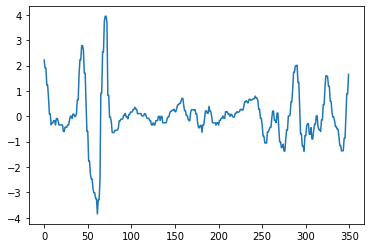

In [13]:
uts_i_test = 0
j_test = 0
q = test[uts_i_test][j_test:j_test + w]
print(len(q))
plt.plot(q)

In [18]:
%%time
e = 20
candidates, e_nn = lbs_search(dataset, q, indexes, r_points, r, w, e)
print(e_nn)

18.0
18.0
14.0
10.0
10.0
4.0
4.0
6.0
2.0
2.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Wall time: 3.05 s


[]

subsequence match label: 2 , query subsequence label: 3


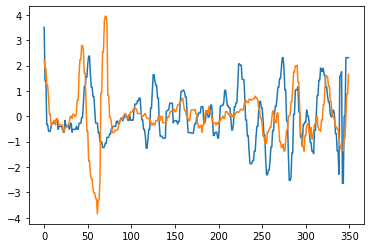

In [19]:

uts_i, j = candidates[e_nn[9]]
plt.plot(dataset[uts_i][j:j+w])
plt.plot(q)
print("subsequence match label:", labels[uts_i], ", query subsequence label:", l_test[uts_i_test])

In [20]:
pred = defaultdict(int)
for i in e_nn:
    uts_i, j = candidates[i]
    pred[labels[uts_i]] += 1
pred

defaultdict(int, {'1': 2, '3': 3, '2': 5})